# Self-distillation with Data2Vec

This notebook demonstrates the canonical self-supervised learning pipeline for computer vision (pre-training, fine-tuning, and evaluation) using the [Data2Vec](https://arxiv.org/abs/2202.03555) framework, which uses the self-distillation technique. The Data2Vec objective is applicable to different modalities of data, including vision, speech, and text but this notebook focuses on the vision modality.

We will use the [STL-10](https://cs.stanford.edu/~acoates/stl10/) dataset for this example. It contains 10 classes of images, each with 500 training images and 800 test images. It also contains 100,000 unlabeled images, which we will use for pre-training with Data2Vec.

This demo is built on top of the [PyTorch Lightning](https://lightning.ai/docs/pytorch/1.9.5/) framework, which provides a high-level interface for training deep learning models and also provides a variety of useful features out-of-the-box such as automatic checkpointing, logging, and distributed training.

## Imports and Constants

In [1]:
if "google.colab" in str(get_ipython()):  # type: ignore # noqa: F821
    %pip install lightning-bolts pytorch_lightning transformers timm wandb

In [2]:
import copy
import math
import os
import random
import warnings
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import pytorch_lightning.callbacks as pt_callbacks
import torch
from pl_bolts.optimizers import LinearWarmupCosineAnnealingLR
from pytorch_lightning.strategies.strategy import Strategy
from pytorch_lightning.trainer.supporters import CombinedLoader
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from timm.data.auto_augment import rand_augment_transform
from timm.data.mixup import Mixup
from timm.data.transforms import RandomResizedCropAndInterpolation
from torch import Tensor, nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import transforms as transform_lib
from torchvision.datasets import STL10
from torchvision.utils import make_grid
from transformers import (
    AutoModel,
    Data2VecVisionConfig,
    Data2VecVisionModel,
    PretrainedConfig,
    ViTConfig,
    ViTModel,
)


warnings.simplefilter(action="once")

/ssd003/projects/aieng/public/ssl_bootcamp_resources/venv/lib/python3.8/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/ssd003/projects/aieng/public/ssl_bootcamp_resources/venv/lib/python3.8/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/ssd003/projects/aieng/public/ssl_bootcamp_resources/venv/lib/python3.8/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_C

In [3]:
# constants
SEED = 202309
IMG_SIZE = 160
PATCH_SIZE = 16
NUM_WORKERS = 4
BATCH_SIZE = 256
MASKING_RATIO = 0.6
INTERPOLATION = "bicubic"
STL10_MEAN: Tuple[float, float, float] = (0.485, 0.456, 0.406)
STL10_STD: Tuple[float, float, float] = (0.229, 0.224, 0.225)

if os.environ.get("USER") is not None and os.environ.get("SLURM_JOB_ID") is not None:
    CKPT_DIR = f"/checkpoint/{os.environ['USER']}/{os.environ['SLURM_JOB_ID']}"
    DATA_DIR = "/ssd003/projects/aieng/public/ssl_bootcamp_resources/datasets/stl10"
else:  # not on Vector's cluster
    CKPT_DIR = "checkpoint"
    DATA_DIR = "data"

pl.seed_everything(SEED, workers=True)

[rank: 0] Global seed set to 202309


202309

## Data

Here we will use the LightningDataModule to define the data loading and processing steps. We will also define a callable for the blockwise masking routine, which is a key component of the Data2Vec framework. Finally, we will visualize samples of the data to see what the masked images look like.

### Datamodule

The [LightningDataModule](https://lightning.ai/docs/pytorch/1.9.5/data/datamodule.html) provides a framework for defining the data loading steps. The module defined below includes steps to:
1. Download the dataset.
2. Split out the validation set from the training sets.
3. Define the transforms to be applied to the images.
4. Define the dataloaders for the training, validation and test sets, with the option of returning both labelled and unlabelled data for the training and validation sets.

In [4]:
class STL10DataModule(pl.LightningDataModule):
    """STL10 DataModule to be used with PyTorch Lightning Trainer."""

    name: str = "stl10"
    num_classes: int = 10
    dims: Tuple[int, int, int] = (3, 96, 96)

    def __init__(
        self,
        data_dir: Optional[str] = None,
        labeled_val_split: float = 0.1,  # 500 samples (50 per class)
        unlabeled_val_split: float = 0.01696,  # 1696 samples
        load_unlabeled: bool = True,  # dict of dataloaders incl. unlabeled data
        train_transforms: Optional[Callable] = None,
        val_transforms: Optional[Callable] = None,
        test_transforms: Optional[Callable] = None,
        batch_size: int = 128,
        num_workers: int = 0,
        pin_memory: bool = True,
        drop_last: bool = False,
        shuffle: bool = True,
        seed: int = 42,
    ) -> None:
        """Initialize the STL10 DataModule."""
        super().__init__()

        self.data_dir = data_dir if data_dir is not None else os.getcwd()
        self.unlabeled_val_split = unlabeled_val_split
        self.labeled_val_split = labeled_val_split
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms
        self.test_transforms = test_transforms
        self.seed = seed
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.load_unlabeled = load_unlabeled

    def prepare_data(self) -> None:
        """Download the various splits of the STL10 dataset."""
        STL10(self.data_dir, split="unlabeled", download=True)
        STL10(self.data_dir, split="train", download=True)
        STL10(self.data_dir, split="test", download=True)

    def setup(self, stage: str) -> None:
        """Create the train, val, and test datasets."""
        if stage == "fit" or stage is None:
            if self.load_unlabeled:
                transforms_for_labeled_data = (
                    self._default_transforms() if self.val_transforms is None else self.val_transforms
                )
            else:
                transforms_for_labeled_data = (
                    self._default_transforms() if self.train_transforms is None else self.train_transforms
                )

            labeled_dataset = STL10(
                self.data_dir,
                split="train",
                download=False,
                transform=transforms_for_labeled_data,
            )

            # stratified random split (keeps class distribution the same in both sets)
            train_indices, val_indices = train_test_split(
                np.arange(len(labeled_dataset)),
                test_size=self.labeled_val_split,
                random_state=self.seed,
                stratify=labeled_dataset.labels,
            )
            self.train_dataset = Subset(labeled_dataset, indices=train_indices)
            self.val_dataset = Subset(labeled_dataset, indices=val_indices)

            if self.load_unlabeled:
                transforms_for_unlabeled_data = (
                    self._default_transforms() if self.train_transforms is None else self.train_transforms
                )
                unlabeled_dataset = STL10(
                    self.data_dir,
                    split="unlabeled",
                    download=False,
                    transform=transforms_for_unlabeled_data,
                )
                num_unlabeled_val_samples = int(self.unlabeled_val_split * len(unlabeled_dataset))
                self.unlabeled_train_data, self.unlabeled_val_data = random_split(
                    unlabeled_dataset,
                    [
                        len(unlabeled_dataset) - num_unlabeled_val_samples,
                        num_unlabeled_val_samples,
                    ],
                    generator=torch.Generator().manual_seed(self.seed),
                )

        if stage == "test":
            transforms = self._default_transforms() if self.test_transforms is None else self.test_transforms
            self.test_dataset = STL10(self.data_dir, split="test", download=False, transform=transforms)

    def train_dataloader(self, batch_size: Optional[int] = None) -> Union[DataLoader, Dict[str, DataLoader]]:
        """Return dataloader(s) for training."""
        if self.load_unlabeled:
            # NOTE: When returning a dict of dataloaders, the pytorch lightning
            # trainer will duplicate samples of the smaller dataset (in this case
            # the labeled dataset) to match the size of the larger dataset. This
            # can be controlled by the `multiple_trainloader_mode` argument of the
            # trainer. The default is `max_size_cycle` which will cycle through the
            # smaller dataset until the larger dataset is exhausted.
            return {
                "labeled": DataLoader(
                    self.train_dataset,
                    batch_size=batch_size if batch_size is not None else self.batch_size,
                    shuffle=self.shuffle,
                    num_workers=self.num_workers,
                    drop_last=self.drop_last,
                    pin_memory=self.pin_memory,
                ),
                "unlabeled": DataLoader(
                    self.unlabeled_train_data,
                    batch_size=batch_size if batch_size is not None else self.batch_size,
                    shuffle=self.shuffle,
                    num_workers=self.num_workers,
                    drop_last=self.drop_last,
                    pin_memory=self.pin_memory,
                ),
            }

        return DataLoader(
            self.train_dataset,
            batch_size=batch_size if batch_size is not None else self.batch_size,
            shuffle=self.shuffle,
            num_workers=self.num_workers,
            drop_last=self.drop_last,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self, batch_size: Optional[int] = None) -> Union[DataLoader, CombinedLoader]:
        """Return a dataloader for the validation set."""
        if self.load_unlabeled:
            loaders = {
                "labeled": DataLoader(
                    self.val_dataset,
                    batch_size=batch_size if batch_size is not None else self.batch_size,
                    shuffle=False,
                    drop_last=False,
                    num_workers=self.num_workers,
                    pin_memory=self.pin_memory,
                ),
                "unlabeled": DataLoader(
                    self.unlabeled_val_data,
                    batch_size=batch_size if batch_size is not None else self.batch_size,
                    shuffle=False,
                    drop_last=False,
                    num_workers=self.num_workers,
                    pin_memory=self.pin_memory,
                ),
            }
            # NOTE: `max_size_cycle` will cycle through the smaller dataset until
            # the larger dataset is exhausted.
            return CombinedLoader(loaders, mode="max_size_cycle")

        return DataLoader(
            self.val_dataset,
            batch_size=batch_size if batch_size is not None else self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        )

    def test_dataloader(self, batch_size: Optional[int] = None) -> DataLoader:
        """Return a dataloader for the test set."""
        return DataLoader(
            self.test_dataset,
            batch_size=batch_size if batch_size is not None else self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        )

    def _default_transforms(self) -> Callable:
        """Return the default transforms for the dataset."""
        return transform_lib.Compose(
            [
                transform_lib.ToTensor(),
                transform_lib.Normalize(mean=STL10_MEAN, std=STL10_STD),
            ]
        )

### Blockwise Masking

The blockwise masking strategy is one of the core parts of the Data2Vec framework. It was originally defined in the [BEiT paper](https://arxiv.org/abs/2106.08254). The idea is to randomly mask blocks of patches at a time instead of individual patches.

The masking routine randomly selects the number of blocks to mask, and then randomly selects the shape of each block. The number of blocks to mask is sampled from a uniform distribution between `min_mask_patches_per_block` and a maximum defined by `masking_ratio`. For vision, Data2Vec defines the masking ratio as 0.6, which means that 60% of the patches will be masked. The routine runs until the desired masking ratio is reached.

In [5]:
class BlockwiseMasking:
    """Blockwise masking transform as described in the BEiT paper."""

    def __init__(
        self,
        img_size: Union[Tuple[int, int], int] = 224,
        patch_size: int = 16,
        masking_ratio: float = 0.6,
        min_mask_patches_per_block: int = 16,
        min_aspect_ratio: float = 0.3,
        max_aspect_ratio: Optional[float] = None,  # default to 1 / min_aspect_ratio
        return_masked_image: bool = False,
    ) -> None:
        """Init."""
        if not isinstance(img_size, tuple):
            self.img_size = (img_size,) * 2  # H, W of image

        self.patch_size = patch_size  # p <- H, W of patch
        self.min_mask_patches_per_block = min_mask_patches_per_block

        self.num_patches = (self.img_size[0] * self.img_size[1]) // (patch_size**2)  # N <- HW / p^2
        self.num_patches_to_mask = int(masking_ratio * self.num_patches)  # M <- masking_ratio * N

        max_aspect_ratio = max_aspect_ratio or 1 / min_aspect_ratio
        self.log_aspect_ratio = (math.log(min_aspect_ratio), math.log(max_aspect_ratio))

        self.patch_grid_size = (
            self.img_size[0] // patch_size,
            self.img_size[1] // patch_size,
        )  # h, w
        self.return_masked_image = return_masked_image

    def _mask(self, mask: Tensor, max_mask_patches_per_block: int) -> int:
        """Blockwise masking routine."""
        delta = 0
        for _ in range(1000):
            block_size = random.uniform(self.min_mask_patches_per_block, max_mask_patches_per_block)
            block_aspect_ratio = math.exp(random.uniform(*self.log_aspect_ratio))
            h = int(round(math.sqrt(block_size * block_aspect_ratio)))
            w = int(round(math.sqrt(block_size / block_aspect_ratio)))
            if w < self.patch_grid_size[1] and h < self.patch_grid_size[0]:
                top = random.randint(0, self.patch_grid_size[0] - h)
                left = random.randint(0, self.patch_grid_size[1] - w)

                num_masked = mask[top : top + h, left : left + w].sum()
                # set mask value for unmasked patches, allow for overlap with
                # already masked patches
                if 0 < h * w - num_masked <= max_mask_patches_per_block:
                    for i in range(top, top + h):
                        for j in range(left, left + w):
                            if mask[i, j] == 0:  # unmasked
                                mask[i, j] = 1  # mask
                                delta += 1  # running mask count

                if delta > 0:
                    break

        return delta

    def generate_mask(self) -> Tensor:
        """Generate blockwise masks for a patch grid."""
        mask = torch.zeros(self.patch_grid_size, dtype=torch.int)
        mask_count = 0
        while mask_count < self.num_patches_to_mask:
            max_mask_patches = self.num_patches_to_mask - mask_count
            max_mask_patches = min(max_mask_patches, self.num_patches)

            delta = self._mask(mask, max_mask_patches)
            if delta == 0:
                break
            mask_count += delta

        return mask

    def __call__(self, image: Tensor) -> Tuple[Tensor, Tensor]:
        """Generate a blockwise mask for a given image tensor."""
        mask = self.generate_mask()
        mask = mask.flatten().bool()
        assert mask.sum() > 0, "No patches were masked."

        if self.return_masked_image:  # for visualizing the mask in input space
            c = image.shape[0]  # channels
            p = self.patch_size
            h = self.patch_grid_size[0]
            w = self.patch_grid_size[1]

            # patchify
            image = image.reshape((c, h, p, w, p)).permute(1, 3, 2, 4, 0).reshape(h * w, p * p * c)

            # apply mask
            image = image * ~mask[:, None]

            # unpatchify
            image = image.reshape((h, w, p, p, c)).permute(4, 0, 2, 1, 3).reshape((c, h * p, w * p))

        return image, mask

    def __repr__(self) -> str:
        """Return a string representation of the object."""
        return (
            f"{self.__class__.__name__}(img_size={self.img_size}, "
            f"patch_size={self.patch_size}, "
            f"min_mask_patches_per_block={self.min_mask_patches_per_block}, "
        )

### Visualize Data Samples

Here we visualize some of the unlabeled data with the block-wise mask applied.

**NOTE:** The default for the `scale` parameter in the `RandomResizedCropAndInterpolation` is (0.08, 1.0). This means that the crop size will be between 8% and 100% of the original image size. This is a good default for datasets with higher resolution images. However, since we are using a smaller image size here, we adjust the scale to (0.25, 1.0) which will give us a minimum crop size of 24 pixels.

In [6]:
dm = STL10DataModule(
    data_dir=DATA_DIR,
    load_unlabeled=True,
    train_transforms=transform_lib.Compose(
        [
            RandomResizedCropAndInterpolation(size=IMG_SIZE, scale=(0.25, 1.0), interpolation=INTERPOLATION),
            transform_lib.ToTensor(),
            BlockwiseMasking(
                img_size=IMG_SIZE,
                patch_size=PATCH_SIZE,
                masking_ratio=MASKING_RATIO,
                min_mask_patches_per_block=8,
                return_masked_image=True,
            ),
        ]
    ),
    num_workers=NUM_WORKERS,
)
dm.prepare_data()
dm.setup("fit")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


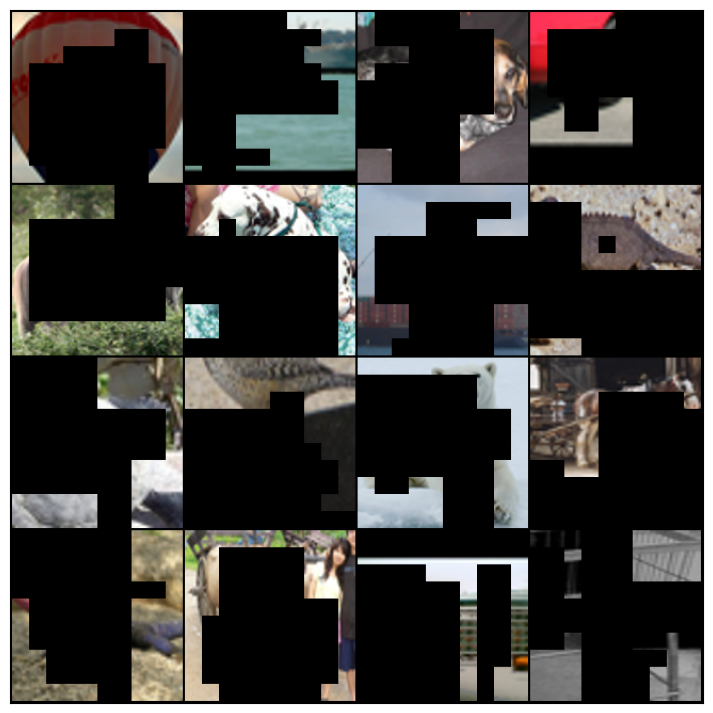

In [7]:
def show_batch(dl: DataLoader) -> None:
    """Show a batch of images from a dataloader."""
    if isinstance(dl, dict):
        dl = dl["unlabeled"]

    for images, targets in dl:
        if isinstance(images, list):
            images = images[0]
        else:
            images, targets = Mixup(0.2, num_classes=STL10DataModule.num_classes)(images, targets)

        _, ax = plt.subplots(figsize=(12, 9))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images.detach(), nrow=int(math.sqrt(images.shape[0]))).permute(1, 2, 0))
        break


show_batch(dm.train_dataloader(batch_size=16))

## Models

Here we define the Data2Vec module as well as a module for image classification.

### Data2Vec

The core idea of the Data2Vec framework is to predict contextualized latent representations from encoded masked views of the input in a self-distillation setup. As shown in the figure below, the target representations are encoded from the full input data and contextualized with the help of the self-attention mechanism of the transformer network. The self-distillation setup includes a teacher and a student network, which are essentially copies of the same network. The teacher network encodes the full input data while the student network encodes masked views of the input data. The student network is trained to regress the teacher network's output for the masked portions of the input data. The outputs to be regressed can consist of the output of multiple layers of the teacher networked, normalized and averaged. While the student network is updated via backpropagation, the teacher network parameters are updated via exponential moving average of the student network's weights. The loss function used to train the student network is the smooth L1 loss, which combines the advantages of both L1 (mean absolute error) and L2 (mean squared error) loss functions.

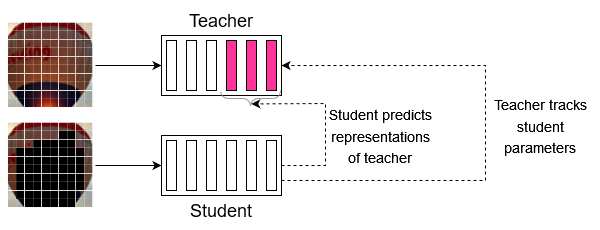

In the previous section, we implemented the blockwise masking strategy, which is used to mask the input to the student network. In this section, we will show the other core components of the Data2Vec framework, including the architecture, the exponential moving average update, and the operations to compute the loss function.

First, we define a module for performing the exponential moving average (EMA) update of the teacher weights. The EMA update is defined as follows:
$$
\Delta = \tau \Delta + (1-\tau) \theta
$$
where $\Delta$ is the teacher weights, $\tau$ is the decay rate, and $\theta$ is the student weights.

The EMA module also updates the $\tau$ value at each iteration. The $\tau$ value can be kept constant or annealed linearly from a starting value to a final value. 

The EMA update is done in 32-bit precision to maintain numerical stability.

In [8]:
class EMAModule:
    """Exponential Moving Average (EMA) module."""

    def __init__(
        self,
        initial_tau: float,
        final_tau: float,
        max_update_epochs: Optional[int] = None,  # default: trainer.max_epochs
        skip_keys: Optional[set] = None,
    ) -> None:
        """Init."""
        self.max_update_epochs = max_update_epochs
        self.skip_keys = skip_keys or set()
        self.initial_tau = initial_tau
        self.current_tau = initial_tau
        self.final_tau = final_tau

    def update_tau(self, pl_module: pl.LightningModule, trainer: pl.Trainer) -> None:
        """Update tau value for the next EMA step."""
        if self.max_update_epochs is None:
            self.max_update_epochs = trainer.max_epochs

        assert self.max_update_epochs <= trainer.max_epochs, (
            "`max_update_epochs` must be less than or equal to max_epochs"
        )
        max_steps = len(trainer.train_dataloader) * self.max_update_epochs
        curr_step = pl_module.global_step

        if curr_step >= max_steps:
            self.current_tau = self.final_tau
        else:
            remainder = self.final_tau - self.initial_tau
            pct_remaining = 1 - (pl_module.global_step / max_steps)

            # linearly anneal from initial_tau to final_tau
            self.current_tau = self.final_tau - remainder * pct_remaining
        pl_module.log("tau", self.current_tau, prog_bar=True, sync_dist=True)

    @torch.inference_mode()
    def update_weights(self, pl_module: pl.LightningModule) -> None:
        """Preform EMA update of the teacher network weights."""
        ema_state_dict = {}
        ema_params = pl_module.teacher.state_dict()

        def _to_float(t: Tensor) -> Tensor:
            """Convert tensor to float32 type."""
            return t.float() if torch.is_floating_point(t) else t

        for key, param in pl_module.student.named_parameters():
            if isinstance(param, dict) or "version" in key:
                continue

            ema_param = _to_float(ema_params[key])  # fp32

            if param.shape != ema_param.shape:
                raise ValueError(
                    "Incompatible tensor shapes between student param and teacher param"
                    + "{} vs. {}".format(param.shape, ema_param.shape)
                )

            if key in self.skip_keys or not param.requires_grad:
                ema_params[key].copy_(param.to(dtype=ema_param.dtype).data)
                ema_param = ema_params[key]
            else:
                # ema_param <- tau * ema_param + (1 - tau) * student_param
                ema_param.mul_(self.current_tau)
                ema_param.add_(param.data.to(dtype=ema_param.dtype), alpha=1 - self.current_tau)

            ema_state_dict[key] = ema_param

        for key, param in pl_module.student.named_buffers():
            ema_state_dict[key] = param

        pl_module.teacher.load_state_dict(ema_state_dict, strict=False)

    def step(self, pl_module: pl.LightningModule, trainer: pl.Trainer) -> None:
        """Perform one EMA update."""
        self.update_weights(pl_module)
        self.update_tau(pl_module, trainer)

The `Data2Vec` LightningModule includes the implementation details of the Data2Vec framework.

In [9]:
class Data2Vec(pl.LightningModule):
    """Data2Vec model."""

    MODALITIES = ["vision", "text", "audio"]

    def __init__(
        self,
        config: PretrainedConfig,
        modality: Literal["vision", "text", "audio"] = "vision",
        initial_tau: float = 0.999,
        final_tau: float = 0.9999,
        tau_anneal_epochs: Optional[int] = None,  # default: trainer.max_epochs
        skip_keys_in_ema: Optional[set] = None,
        average_top_k_layers: int = 6,
        normalize_averaged_targets: bool = False,
        layer_norm_target_layer_outputs: bool = True,
        instance_norm_target_layer_outputs: bool = False,
        weight_decay: float = 0.05,
        warmup_epochs: Optional[int] = None,  # default: 5% of trainer.max_epochs
        learning_rate: float = 4e-4,
        min_learning_rate: float = 1e-6,
        loss_beta: float = 2.0,
        loss_scale: Optional[float] = None,  # default: 1 / sqrt(embed_dim)
    ) -> None:
        """Initialize Data2Vec model."""
        super().__init__()
        assert modality in self.MODALITIES, f"Modality must be one of {self.MODALITIES}"
        self.save_hyperparameters()

        if isinstance(config, ViTConfig):
            self.student = ViTModel(config, use_mask_token=True)
        else:
            self.student = AutoModel.from_config(config)
        self.teacher = copy.deepcopy(self.student)
        self.teacher.requires_grad_(False)  # disable gradient for teacher network

        self.embed_dim = self.student.config.hidden_size
        self.regression_head = self._build_regression_head()

        self.loss_scale = loss_scale if loss_scale is not None else 1 / math.sqrt(self.embed_dim)

        # callback for Exponential Moving Average (EMA) update of the teacher model
        self.ema_callback = EMAModule(
            initial_tau=self.hparams.initial_tau,
            final_tau=self.hparams.final_tau,
            max_update_epochs=self.hparams.tau_anneal_epochs,
            skip_keys=skip_keys_in_ema,
        )

    def _build_regression_head(self) -> nn.Module:
        """Build regression head for the student model."""
        if self.hparams.modality == "text":
            return nn.Sequential(
                nn.Linear(self.embed_dim, self.embed_dim * 2),
                nn.GELU(),
                nn.Linear(self.embed_dim * 2, self.embed_dim),
            )

        if self.hparams.modality in ["audio", "vision"]:
            return nn.Linear(self.embed_dim, self.embed_dim)

    @staticmethod
    def _common_forward(
        model: nn.Module, input_values: Tensor, **kwargs: Any
    ) -> Dict[str, Union[Tensor, List[Tensor]]]:
        """Return hidden states of the model."""
        outputs = model(input_values, output_hidden_states=True, return_dict=True, **kwargs)

        encoder_states = outputs["hidden_states"][:-1]
        encoder_out: Tensor = outputs["hidden_states"][-1]  # output of last layer

        # remove [CLS] token from outputs
        encoder_states = [output[:, 1:, :] for output in encoder_states]
        encoder_out = encoder_out[:, 1:, :]

        out = {"encoder_states": encoder_states, "encoder_out": encoder_out}

        if "attentions" in outputs:
            attentions = outputs["attentions"]
            attentions = [output[:, 1:, 1:] for output in attentions]
            out["attentions"] = attentions

        return out

    def forward_student(
        self, input_values: Tensor, mask: Optional[Tensor] = None, **kwargs: Any
    ) -> Dict[str, Union[Tensor, List[Tensor]]]:
        """Run a forward pass for the student network."""
        if self.hparams.modality == "vision":
            kwargs["bool_masked_pos"] = mask
        else:
            kwargs["attention_mask"] = mask

        out = self._common_forward(self.student, input_values, **kwargs)

        if self.hparams.modality == "vision":  # normalize the output of the last layer
            out["encoder_out"] = F.layer_norm(
                out["encoder_out"].float(),  # type: ignore
                out["encoder_out"].shape[-1:],  # type: ignore
                eps=1e-12,  # type: ignore
            )
        return out

    def forward_teacher(self, input_values: Tensor, **kwargs: Any) -> Tensor:
        """Run a forward pass for the teacher network."""
        with torch.no_grad():
            self.teacher.eval()
            out = self._common_forward(self.teacher, input_values, **kwargs)
            all_tgts = out["encoder_states"]

        # select the top k layers
        top_k_tgts = all_tgts[-self.hparams.average_top_k_layers :]

        # normalize the target representations
        if self.hparams.layer_norm_target_layer_outputs:
            top_k_tgts = [F.layer_norm(tgt.float(), tgt.shape[-1:], eps=1e-12) for tgt in top_k_tgts]
        elif self.hparams.instance_norm_target_layer_outputs:
            top_k_tgts = [
                F.instance_norm(tgt.transpose(1, 2).float(), eps=1e-12).transpose(1, 2) for tgt in top_k_tgts
            ]

        # average the representations of the top-k layers
        y: Tensor = sum(top_k_tgts) / len(top_k_tgts)

        if self.hparams.normalize_averaged_targets and self.hparams.modality in [
            "vision",
            "text",
        ]:
            y = F.layer_norm(y.float(), y.shape[-1:], eps=1e-12)

        if self.hparams.normalize_averaged_targets and self.hparams.modality == "audio":
            y = F.instance_norm(y.transpose(1, 2), eps=1e-12).transpose(1, 2)

        return y

    def forward(self, input_values: Tensor, mask: Tensor, **kwargs: Any) -> Tuple[Tensor, Tensor]:
        """Forward pass of the model."""
        pred = self.forward_student(input_values, mask, **kwargs)["encoder_out"]
        tgt = self.forward_teacher(input_values, **kwargs)

        # select only the masked tokens; use fp32 for numerical stability
        pred = pred[mask].float()
        tgt = tgt[mask].float()

        # predict the target representation from the student representation
        pred = self.regression_head(pred)

        return pred, tgt

    def _compute_loss(self, batch: Any) -> Tensor:
        """Compute loss."""
        input_values, mask = batch["unlabeled"][0]
        pred, tgt = self(input_values, mask)

        if self.hparams.loss_beta == 0.0:
            loss = F.mse_loss(pred, tgt, reduction="none").sum(dim=-1).sum()
        else:
            loss = F.smooth_l1_loss(pred, tgt, reduction="none", beta=self.hparams.loss_beta).sum(dim=-1).sum()
        if self.hparams.loss_scale is not None and self.hparams.loss_scale > 0:
            loss = loss * self.hparams.loss_scale

        return loss

    def training_step(self, batch: Any, batch_idx: int) -> Tensor:
        """Run the training step."""
        loss = self._compute_loss(batch)
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            sync_dist=True,
            batch_size=self.trainer.datamodule.batch_size,
        )

        return loss

    def on_train_batch_end(self, outputs: Any, batch: Any, batch_idx: int) -> None:
        """Update the parameters of the teacher model using EMA."""
        self.ema_callback.step(self, self.trainer)

    def validation_step(self, batch: Any, batch_idx: int) -> None:
        """Run the validation step."""
        loss = self._compute_loss(batch)
        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            sync_dist=True,
            batch_size=self.trainer.datamodule.batch_size,
        )

    def configure_optimizers(
        self,
    ) -> Dict[str, Union[optim.Optimizer, optim.lr_scheduler._LRScheduler]]:
        """Configure optimizer and learning rate scheduler."""
        optimizer = optim.AdamW(
            self.parameters(),
            betas=(0.9, 0.999),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )

        max_epochs = self.trainer.max_epochs
        if self.hparams.warmup_epochs is None:
            self.hparams.warmup_epochs = max(1, int(max_epochs * 0.05))
        scheduler = LinearWarmupCosineAnnealingLR(
            optimizer,
            warmup_epochs=self.hparams.warmup_epochs,
            max_epochs=max_epochs,
            warmup_start_lr=self.hparams.min_learning_rate,
            eta_min=self.hparams.min_learning_rate,
        )

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

Next, we define a callback for performing K-nearest neighbour (KNN) evaluation during training to give us an idea of how good the learned representations are. We use the representations from the student network for the labelled training set to fit the KNN classifier, and then evaluate the accuracy of the classifier on the validation set.

In [10]:
def concat_all_gather(tensor: Tensor, strategy: Strategy) -> Tensor:
    """Performs all_gather operation on the provided tensors."""
    return strategy.all_gather(tensor).view(-1, *tensor.shape[1:])


class OnlineKNNEvaluator(pt_callbacks.Callback):
    """Callback to perform KNN evaluation during pretraining."""

    def __init__(self, k: int = 1) -> None:
        """Initialize the callback."""
        self.k = k
        self.knn_evaluator = None
        self._train_features: List[Tensor] = []
        self._train_targets: List[Tensor] = []
        self._val_features: List[Tensor] = []
        self._val_targets: List[Tensor] = []

    def _extract_and_accumulate_features(
        self, pl_module: pl.LightningModule, batch: Dict[str, Tensor], stage: str
    ) -> None:
        """Extract and accumulate features and targets for KNN evaluation."""
        inp, tgt = batch["labeled"]
        inp = inp.to(pl_module.device)
        tgt = tgt.to(pl_module.device)

        with torch.no_grad():
            original_mode = pl_module.training
            pl_module.train(False)

            feats = pl_module.student(inp)[0]
            if hasattr(pl_module.student.config, "use_mean_pooling") and pl_module.student.config.use_mean_pooling:
                # Mean pool the final hidden states of the patch tokens
                patch_tokens = feats[:, 1:, :]
                feats = F.layer_norm(patch_tokens.mean(1), patch_tokens.shape[-1:])
            else:
                feats = feats[:, 0]
                feats = F.normalize(feats, dim=1)
            pl_module.train(original_mode)

        if stage == "train":
            self._train_features.append(feats)
            self._train_targets.append(tgt)
        elif stage == "val":
            self._val_features.append(feats)
            self._val_targets.append(tgt)
        else:
            raise ValueError(f"Invalid stage: {stage}")

    def on_train_batch_end(
        self,
        trainer: pl.Trainer,
        pl_module: pl.LightningModule,
        outputs: Any,
        batch: Dict[str, Tensor],
        batch_idx: int,
    ) -> None:
        """Accumulate features and targets for fitting the KNN classifier."""
        # NOTE: when using multiple dataloaders, the smaller dataset will be
        # duplicated by default so we need to check the batch_idx to avoid duplicates
        num_batches = int(len(trainer.datamodule.train_dataset) / trainer.datamodule.batch_size)
        if batch_idx > num_batches:
            return
        self._extract_and_accumulate_features(pl_module, batch, "train")

    def on_train_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        """Clear the accumulated training features and targets."""
        # reset the features and targets
        # NOTE: validation_epoch_end is called before train_epoch_end
        self._train_features = []
        self._train_targets = []

    def on_validation_batch_end(
        self,
        trainer: pl.Trainer,
        pl_module: pl.LightningModule,
        outputs: Any,
        batch: Dict[str, Tensor],
        batch_idx: int,
        dataloader_idx: int,
    ) -> None:
        """Extract and accumulate features and targets for KNN evaluation."""
        if trainer.state.stage == "sanity_check":
            return

        # NOTE: when using multiple dataloaders, the smaller dataset will be
        # duplicated by default so we need to check the batch_idx to avoid
        # duplicates. Further note that doing this will force dropping the last
        # batch of the smaller dataset.
        num_batches = int(len(trainer.datamodule.val_dataset) / trainer.datamodule.batch_size)
        if batch_idx > num_batches:
            return

        self._extract_and_accumulate_features(pl_module, batch, "val")

    def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        """Fit and evaluate the classifier on the accumulated features and targets."""
        if trainer.state.stage == "sanity_check":
            return

        # concatenate the features and targets and ensure that the number of
        # features and targets is not greater than the number of samples in the
        # dataset
        X_train = torch.concat(self._train_features)
        y_train = torch.concat(self._train_targets)
        num_train_samples = len(trainer.datamodule.train_dataset)
        if X_train.shape[0] > num_train_samples:
            X_train = X_train[:num_train_samples]
            y_train = y_train[:num_train_samples]

        X_val = torch.concat(self._val_features)
        y_val = torch.concat(self._val_targets)
        num_val_samples = len(trainer.datamodule.val_dataset)
        if X_val.shape[0] > num_val_samples:
            X_val = X_val[:num_val_samples]
            y_val = y_val[:num_val_samples]

        accel = (
            trainer.accelerator_connector
            if hasattr(trainer, "accelerator_connector")
            else trainer._accelerator_connector
        )

        if accel.is_distributed:  # gather representations from other gpus
            X_train = concat_all_gather(X_train, trainer.strategy)
            y_train = concat_all_gather(y_train, trainer.strategy)
            X_val = concat_all_gather(X_val, trainer.strategy)
            y_val = concat_all_gather(y_val, trainer.strategy)

        # convert to numpy
        X_train = X_train.cpu().numpy()
        y_train = y_train.cpu().numpy()
        X_val = X_val.cpu().numpy()
        y_val = y_val.cpu().numpy()

        self.knn_evaluator = KNeighborsClassifier(n_neighbors=self.k, metric="cosine", weights="distance").fit(
            X_train, y_train
        )
        acc = self.knn_evaluator.score(X_val, y_val)  # type: ignore

        pl_module.log("knn_acc", acc, prog_bar=True, batch_size=trainer.datamodule.batch_size)

        # reset the features and targets
        self._val_features = []
        self._val_targets = []

### Image Classifier: Backbone + Linear Head

In this section, we define a LightningModule for performing image classification with a backbone and a linear head. We will use this module to train and finetune the backbone for image classification on the labelled set of the STL-10 dataset.

In [11]:
class ImageClassifier(pl.LightningModule):
    """Image classifier module."""

    def __init__(
        self,
        encoder: Data2VecVisionModel,
        mixup_alpha: float = 0.2,
        label_smoothing: float = 0.1,
        weight_decay: float = 0.03,
        warmup_epochs: Optional[int] = None,  # default to 5% of trainer.max_epochs
        learning_rate: float = 3e-4,
        min_lr: float = 1e-6,
    ) -> None:
        """Init."""
        super().__init__()
        self.save_hyperparameters(ignore=["encoder"])

        self.encoder = encoder
        self.head = nn.Linear(encoder.config.hidden_size, encoder.config.num_labels)
        self.mixup = Mixup(
            mixup_alpha=mixup_alpha,
            num_classes=encoder.config.num_labels,
            label_smoothing=label_smoothing,
        )

    def forward(self, batch: Any) -> Tuple[Tensor, Tensor, Tensor]:
        """Perform a forward pass and calculate the loss."""
        x, y = batch
        last_hidden_state = self.encoder(x)[0]
        if hasattr(self.encoder.config, "use_mean_pooling") and self.encoder.config.use_mean_pooling:
            pooled_output = F.layer_norm(last_hidden_state[:, 1:, :].mean(dim=1), last_hidden_state.shape[-1:])
        else:
            pooled_output = last_hidden_state[:, 0]  # [CLS] token

        logits = self.head(pooled_output)

        if self.hparams.mixup_alpha > 0 and self.trainer.state.stage in [
            "train",
            "tune",
        ]:
            loss = torch.mean(-y * F.log_softmax(logits.float(), dim=-1))
        else:
            loss = F.cross_entropy(
                logits.float(),
                y,
                label_smoothing=self.hparams.label_smoothing if self.trainer.state.stage in ["train", "tune"] else 0.0,
            )

        return loss, logits, y

    def training_step(self, batch: Any, batch_idx: int) -> Tensor:
        """Run the training step."""
        if self.hparams.mixup_alpha > 0:
            batch = self.mixup(batch[0], batch[1])

        loss, logits, labels = self(batch)
        self.log("train_loss", loss, sync_dist=True, prog_bar=True)

        # compute and log accuracy
        if self.hparams.mixup_alpha > 0:
            labels = labels.argmax(dim=-1)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        self.log("train_acc", acc, sync_dist=True, prog_bar=True)

        return loss

    def validation_step(self, batch: Any, batch_idx: int) -> None:
        """Run the validation step."""
        loss, logits, labels = self(batch)
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        self.log("val_loss", loss, sync_dist=True, prog_bar=True)
        self.log("val_acc", acc, sync_dist=True, prog_bar=True)

    def test_step(self, batch: Any, batch_idx: int) -> None:
        """Run the test step."""
        _, logits, labels = self(batch)

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        self.log("test_acc", acc, sync_dist=True, prog_bar=True)

    def configure_optimizers(
        self,
    ) -> Dict[str, Union[optim.Optimizer, optim.lr_scheduler._LRScheduler]]:
        """Configure the optimizer and learning rate scheduler."""
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )

        max_epochs = self.trainer.max_epochs
        if self.hparams.warmup_epochs is None:
            self.hparams.warmup_epochs = max(1, int(max_epochs * 0.05))
        scheduler = LinearWarmupCosineAnnealingLR(
            optimizer,
            warmup_epochs=self.hparams.warmup_epochs,
            max_epochs=max_epochs,
            warmup_start_lr=self.hparams.min_lr,
            eta_min=self.hparams.min_lr,
        )

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

## Training

In the section, we configure the models, datamodule, and trainer.

We use a small [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) network to make sure that the training is fast and that we can easily experiment with different hyperparameters. The reduction in the size of the network also takes into account the size of the dataset as well as the size of the images in the dataset.

In [12]:
# configuration for ViT-small, but with image_size=IMG_SIZE and patch_size=PATCH_SIZE
config = Data2VecVisionConfig(
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    hidden_size=384,
    num_hidden_layers=12,
    num_attention_heads=6,
    intermediate_size=1536,
    drop_path_rate=0.1,
    hidden_dropout_prob=0.1,
    use_shared_relative_position_bias=True,
    use_mask_token=True,
    use_mean_pooling=True,
    return_dict=True,
    output_hidden_states=True,
    num_labels=STL10DataModule.num_classes,
    problem_type="single_label_classification",
)
print(config)

Data2VecVisionConfig {
  "attention_probs_dropout_prob": 0.0,
  "auxiliary_channels": 256,
  "auxiliary_concat_input": false,
  "auxiliary_loss_weight": 0.4,
  "auxiliary_num_convs": 1,
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "image_size": 160,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "layer_scale_init_value": 0.1,
  "model_type": "data2vec-vision",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "out_indices": [
    3,
    5,
    7,
   

Next, we define the transforms that will be applied to each image. For Data2Vec, we use the same transforms as defined in the paper. The differences are related to the fact that we are using a different image size: we use of minimum scale of 0.25 (instead of the default 0.08) in the random resized crop transform, and we use a minimum block size of 8 (instead of 16) in the block-wise masking transform.

The training transforms used here (including mixup, weight decay, dropout and stochastic depth parameters) are similar to the light1 setting in the [How to train your ViT](https://arxiv.org/abs/2106.10270) paper.

In [13]:
data2vec_transforms = transform_lib.Compose(
    [
        transform_lib.ColorJitter(0.4, 0.4, 0.4),
        transform_lib.RandomHorizontalFlip(p=0.5),
        RandomResizedCropAndInterpolation(size=IMG_SIZE, scale=(0.25, 1.0), interpolation=INTERPOLATION),
        transform_lib.ToTensor(),
        transform_lib.Normalize(mean=STL10_MEAN, std=STL10_STD),
        BlockwiseMasking(
            img_size=IMG_SIZE,
            patch_size=PATCH_SIZE,
            masking_ratio=MASKING_RATIO,
            min_mask_patches_per_block=8,
            return_masked_image=False,  # we don't need the masked image for training
        ),
    ]
)

train_transforms = transform_lib.Compose(
    [
        transform_lib.RandomHorizontalFlip(p=0.5),
        RandomResizedCropAndInterpolation(size=IMG_SIZE, scale=(0.25, 1.0), interpolation=INTERPOLATION),
        rand_augment_transform("rand-m10-n2-mstd0.5", hparams={}),
        transform_lib.ToTensor(),
        transform_lib.Normalize(mean=STL10_MEAN, std=STL10_STD),
    ]
)

test_transforms = transform_lib.Compose(
    [
        transform_lib.Resize((IMG_SIZE, IMG_SIZE), interpolation=3),
        transform_lib.ToTensor(),
        transform_lib.Normalize(mean=STL10_MEAN, std=STL10_STD),
    ]
)

/ssd003/projects/aieng/public/ssl_bootcamp_resources/venv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [14]:
%env "WANDB_NOTEBOOK_NAME" "data2vec_vision.ipynb"
%env WANDB_SILENT=True

env: "WANDB_NOTEBOOK_NAME"="data2vec_vision.ipynb"
env: WANDB_SILENT=True


### Baseline: Training from scratch

You can view some of the logs of past runs [here](https://wandb.ai/vector-ssl-bootcamp/data2vec-vision-baseline)

In [15]:
# load the data
dm = STL10DataModule(
    data_dir=DATA_DIR,
    load_unlabeled=False,
    train_transforms=train_transforms,
    val_transforms=test_transforms,
    test_transforms=test_transforms,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    seed=SEED,
)

# load the model
model = ImageClassifier(
    encoder=Data2VecVisionModel(config),
    learning_rate=5e-4,
    weight_decay=0.03,
    warmup_epochs=10,
    mixup_alpha=0.2,
)

# configure the trainer
baseline_dir = os.path.join(CKPT_DIR, "baseline")
trainer = pl.Trainer(
    accelerator="auto",
    precision="16",
    benchmark=True,
    max_epochs=150,
    log_every_n_steps=5,
    default_root_dir=baseline_dir,
    callbacks=[
        pt_callbacks.RichProgressBar(),
        pt_callbacks.LearningRateMonitor(logging_interval="step"),
        pt_callbacks.ModelCheckpoint(
            dirpath=baseline_dir,
            filename="data2vec-vision-small-baseline-{epoch:02d}-{val_acc:.2f}",
            monitor="val_loss",
            save_top_k=3,
            mode="min",
        ),
    ],
    # logger=WandbLogger(
    #     project="data2vec-vision-baseline",
    #     name="data2vec-vision-small-patch16-stl10_160",
    #     entity="vector-ssl-bootcamp",
    #     save_dir=baseline_dir,
    # ),
)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)
# wandb.finish()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_25594/1335475913.py:102: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type                ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder │ Data2VecVisionModel │ 21.6 M │
│ 1 │ head    │ Linear              │  3.9 K │
└───┴─────────┴─────────────────────┴────────┘

Trainable params: 21.6 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 21.6 M                                                                                               
Total estimated model params size (MB): 43

SLURM auto-requeueing enabled. Setting signal handlers.


Output()

`Trainer.fit` stopped: `max_epochs=150` reached.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5914999842643738     │
└───────────────────────────┴───────────────────────────┘

### Data2Vec Pre-training

You can view the logs of some of past pre-training runs [here](https://wandb.ai/vector-ssl-bootcamp/data2vec-vision-pretrain).

In [17]:
# load the model
model = Data2Vec(
    config,
    learning_rate=3e-4,
    weight_decay=0.05,
    initial_tau=0.999,
    final_tau=0.99999,
    tau_anneal_epochs=None,  # default: trainer.max_epochs
    average_top_k_layers=3,
    normalize_averaged_targets=True,
    layer_norm_target_layer_outputs=True,
    instance_norm_target_layer_outputs=False,
    loss_beta=2.0,
)

# load the data
dm = STL10DataModule(
    data_dir=DATA_DIR,
    train_transforms=data2vec_transforms,
    val_transforms=test_transforms,
    load_unlabeled=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    seed=SEED,
)

# configure the trainer
pretrain_dir = os.path.join(CKPT_DIR, "pretrain")
trainer = pl.Trainer(
    accelerator="auto",
    benchmark=True,
    precision="16",
    max_epochs=100,
    gradient_clip_val=3.0,
    default_root_dir=pretrain_dir,
    callbacks=[
        pt_callbacks.RichProgressBar(),
        pt_callbacks.LearningRateMonitor(logging_interval="step"),
        pt_callbacks.ModelCheckpoint(
            dirpath=pretrain_dir,
            filename="data2vec-vision-small-patch16-stl10_160-{epoch:02d}",
            monitor="val_loss",
            save_last=True,
            save_top_k=5,
            mode="min",
        ),
        OnlineKNNEvaluator(k=1),
    ],
    # logger=WandbLogger(
    #     project="data2vec-vision-pretrain",
    #     name="data2vec-vision-small-patch16-stl10_160",
    #     entity="vector-ssl-bootcamp",
    #     save_dir=pretrain_dir,
    # ),
)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model, datamodule=dm)
# wandb.finish()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_25594/145728249.py:220: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name            ┃ Type                ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ student         │ Data2VecVisionModel │ 21.6 M │
│ 1 │ teacher         │ Data2VecVisionModel │ 21.6 M │
│ 2 │ regression_head │ Linear              │  147 K │
└───┴─────────────────┴─────────────────────┴────────┘

Trainable params: 21.7 M                                                                                           
Non-trainable params: 21.6 M                                                                                       
Total params: 43.3 M                                                                                               
Total estimated model params size (MB): 86

SLURM auto-requeueing enabled. Setting signal handlers.


Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


### Fine-tuning

You can view some of the logs of past fine-tuning runs [here](https://wandb.ai/vector-ssl-bootcamp/data2vec-vision-finetune)

In [19]:
# load the model
ckpt_path = os.path.join(CKPT_DIR, "pretrain", "last.ckpt")
pretrained_model = Data2Vec.load_from_checkpoint(ckpt_path, strict=False, config=config)
# pretrained_model.freeze() # uncomment to perform linear evaluation

model = ImageClassifier(
    encoder=pretrained_model.student,
    learning_rate=3e-4,
    warmup_epochs=10,
    mixup_alpha=0.2,
    label_smoothing=0.1,
    weight_decay=0.03,
)

# load the data
dm = STL10DataModule(
    data_dir=DATA_DIR,
    load_unlabeled=False,
    train_transforms=train_transforms,
    val_transforms=test_transforms,
    test_transforms=test_transforms,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    seed=SEED,
)

# configure the trainer
finetune_dir = os.path.join(CKPT_DIR, "finetune")
trainer = pl.Trainer(
    accelerator="auto",
    precision="16",
    benchmark=True,
    max_epochs=100,
    auto_lr_find=True,
    log_every_n_steps=5,
    default_root_dir=finetune_dir,
    callbacks=[
        pt_callbacks.RichProgressBar(),
        pt_callbacks.LearningRateMonitor(logging_interval="step"),
        pt_callbacks.ModelCheckpoint(
            dirpath=finetune_dir,
            filename="data2vec-vision-small-stl10_160-ft-{epoch:02d}-{val_acc:.2f}",
            monitor="val_loss",
            save_top_k=3,
            mode="min",
        ),
    ],
    # logger=WandbLogger(
    #     project="data2vec-vision-finetune",
    #     name="data2vec-vision-small-stl10_160",
    #     entity="vector-ssl-bootcamp",
    #     save_dir=finetune_dir,
    # ),
)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)
# wandb.finish()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_25594/1335475913.py:102: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type                ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder │ Data2VecVisionModel │ 21.6 M │
│ 1 │ head    │ Linear              │  3.9 K │
└───┴─────────┴─────────────────────┴────────┘

Trainable params: 21.6 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 21.6 M                                                                                               
Total estimated model params size (MB): 43

SLURM auto-requeueing enabled. Setting signal handlers.


Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7878749966621399     │
└───────────────────────────┴───────────────────────────┘